In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Module
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import MaxPool1d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import datetime as datetime
from timeit import default_timer as timer

In [2]:
data_pre = pd.read_csv("Slow_amp_pre.csv", header=None)
data_post = pd.read_csv("Slow_amp_post.csv", header=None)
data_whole = pd.read_csv("Slow_amp_whole.csv", header=None)

n_rows = data_pre.shape[0]
n_cols = data_whole.shape[1] - (data_pre.shape[1] + data_post.shape[1])

data_miss = pd.DataFrame(np.zeros([n_rows, n_cols])*np.nan)

In [3]:
data_pre_vals = data_pre[:].values
data_post_vals = data_post[:].values
data_whole_vals = data_whole[:].values

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
dummy_data = pd.concat([data_pre, data_post], axis=1,ignore_index=True)

In [6]:
data = scaler.fit_transform(dummy_data[:].values.reshape(-1,1)).reshape(dummy_data.shape[0],dummy_data.shape[1])

In [7]:
pre_data_scaled = data[:,:data_pre.shape[1]]
post_data_scaled = data[:, data_pre.shape[1]:data.shape[1]]

<ipython-input-8-2020cab4562a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


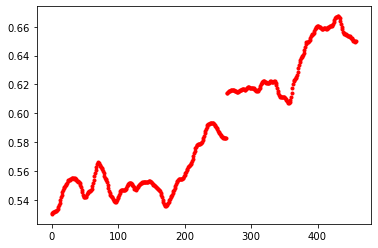

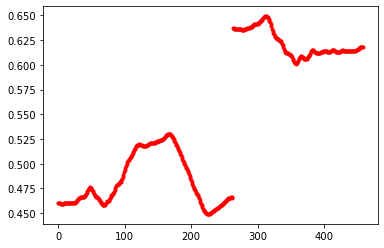

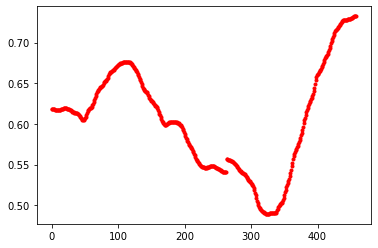

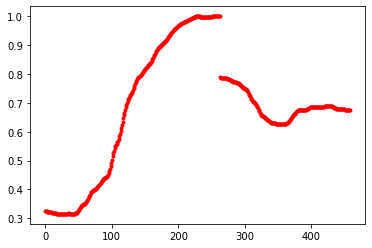

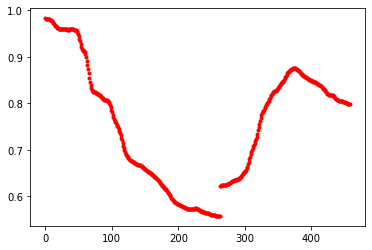

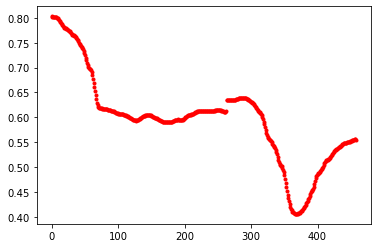

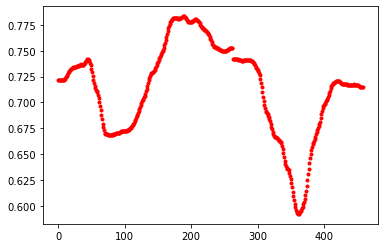

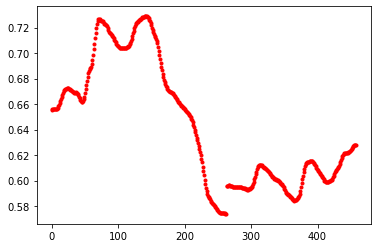

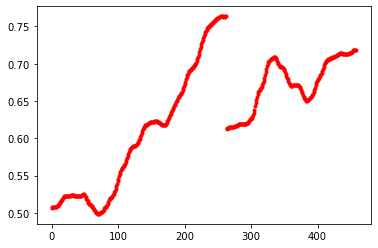

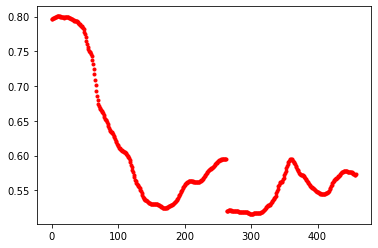

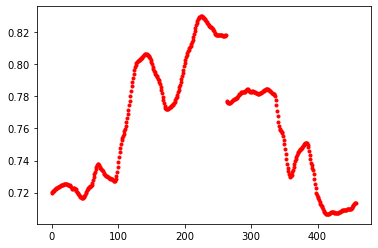

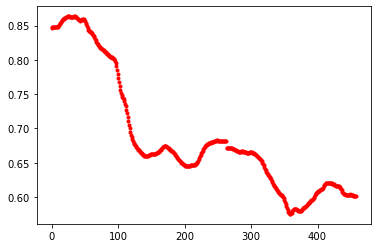

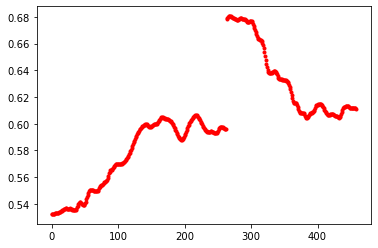

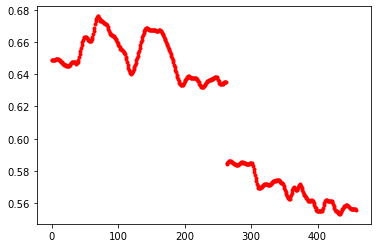

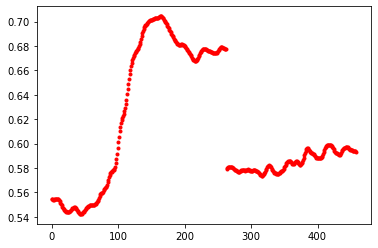

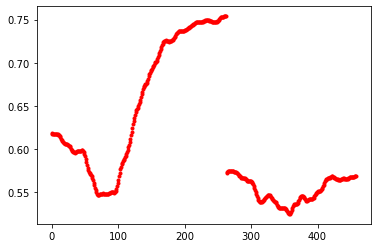

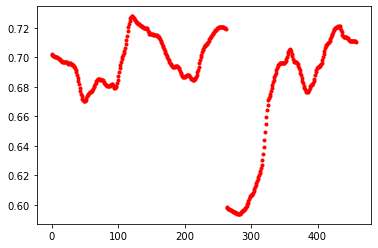

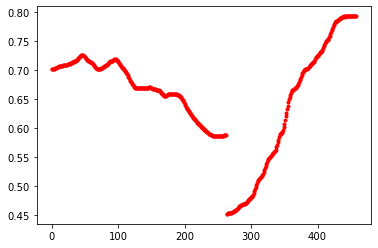

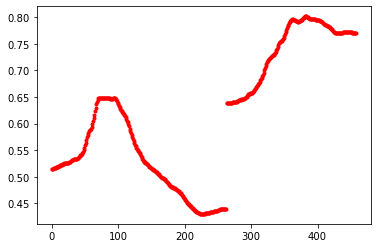

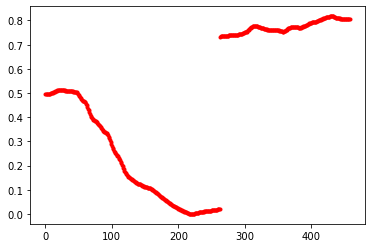

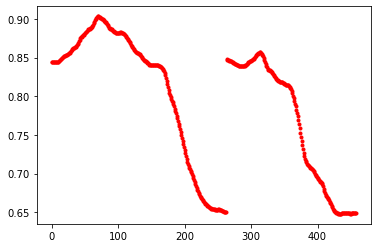

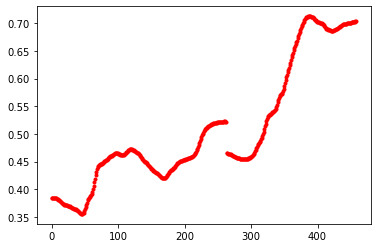

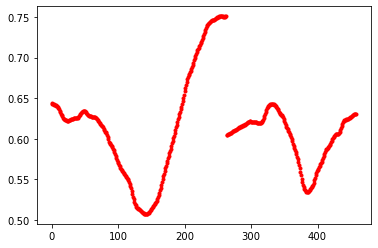

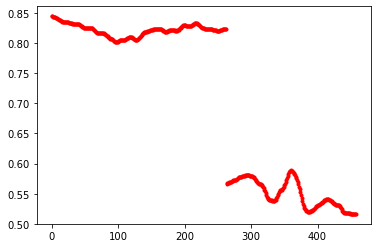

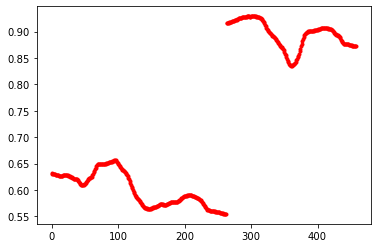

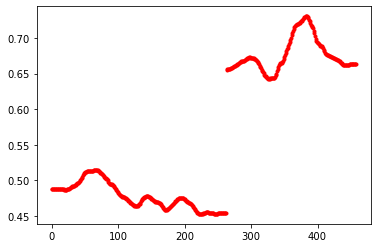

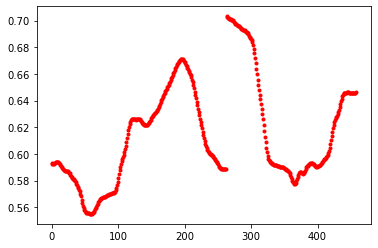

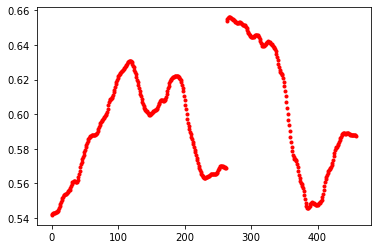

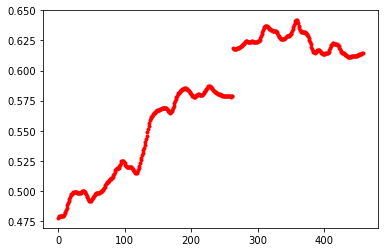

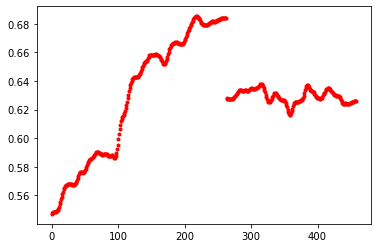

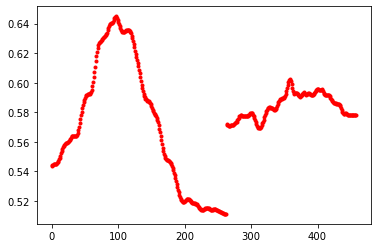

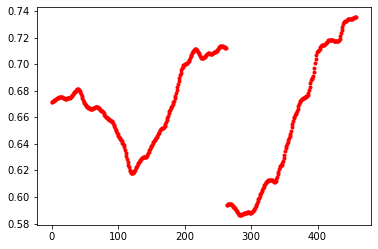

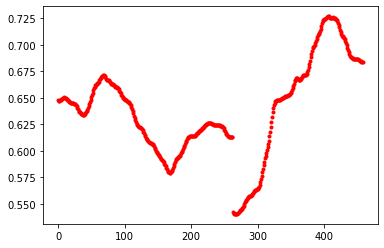

In [8]:
for i in range(len(data)):
    plt.figure(i)
    plt.plot(data[i,:],'r.')

In [9]:
post_data_scaled.shape[1]

196

<ipython-input-10-b956160a0509>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


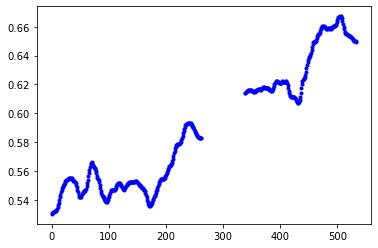

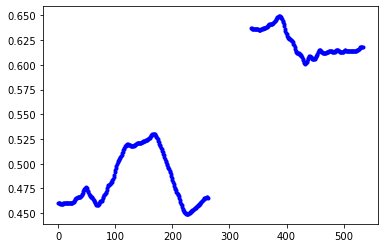

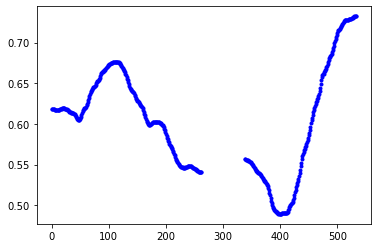

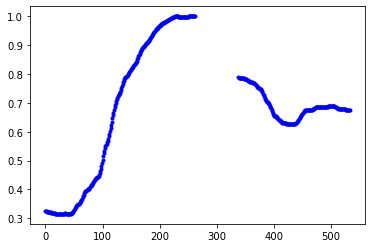

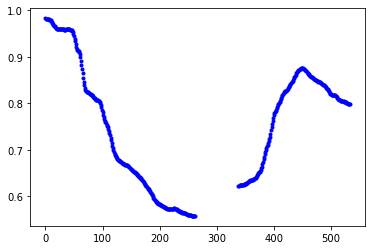

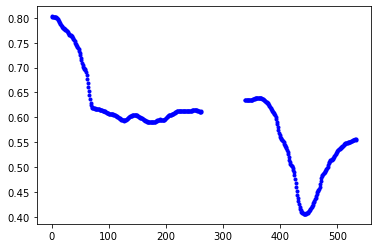

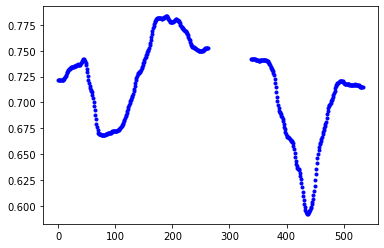

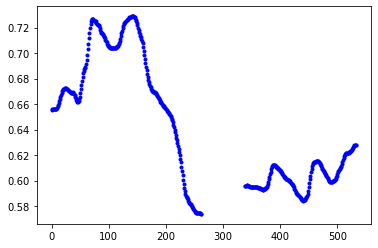

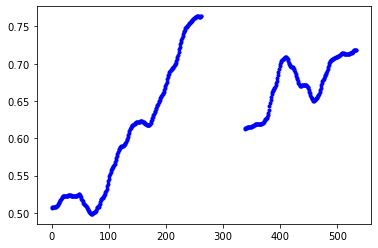

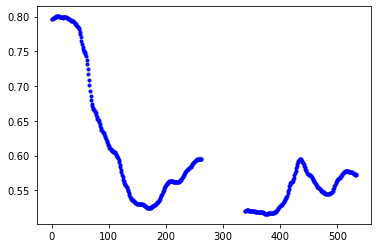

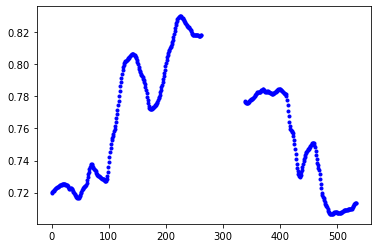

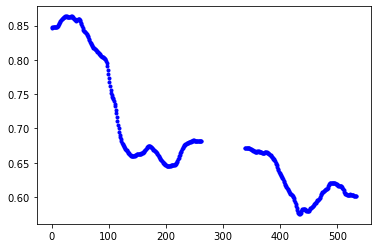

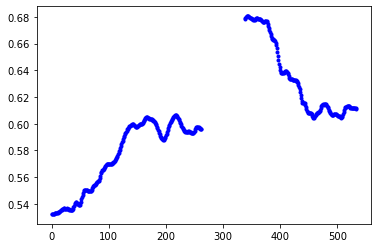

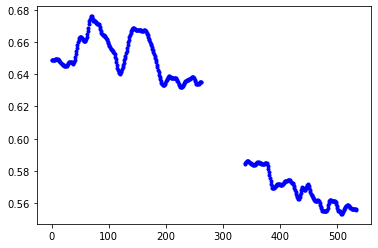

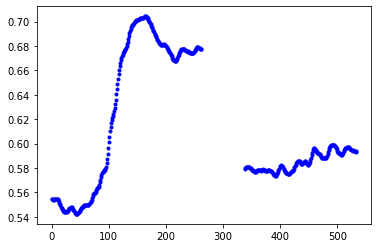

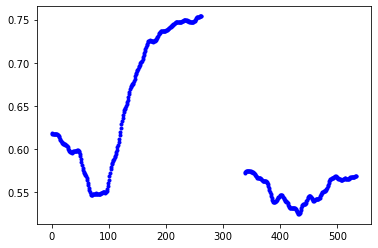

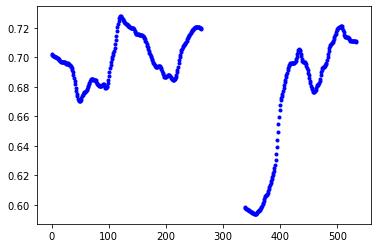

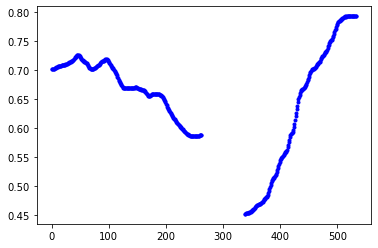

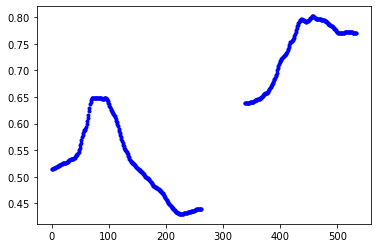

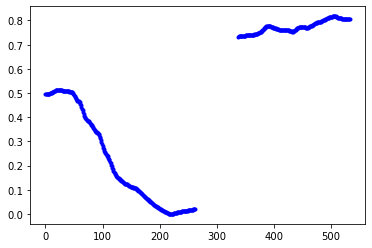

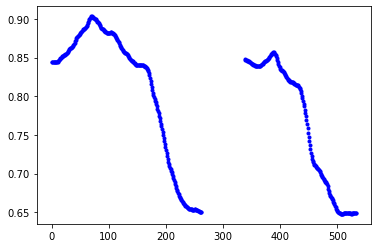

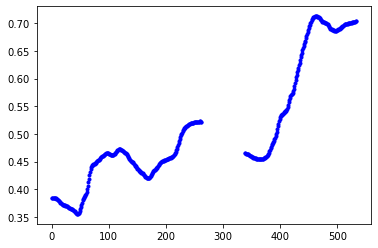

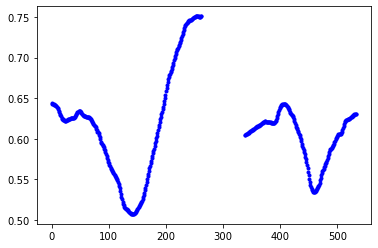

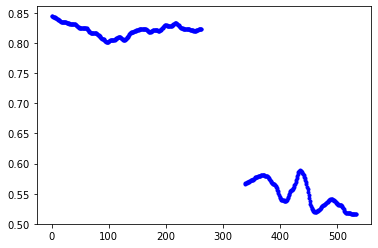

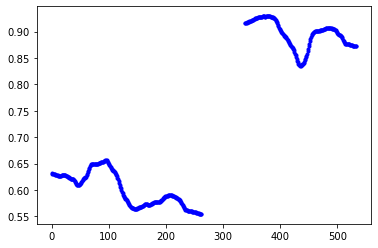

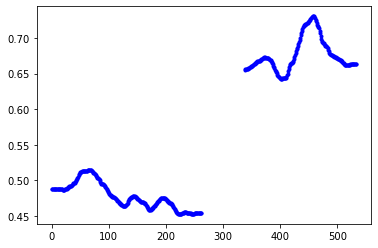

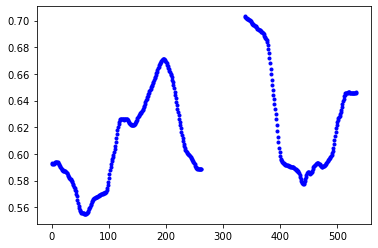

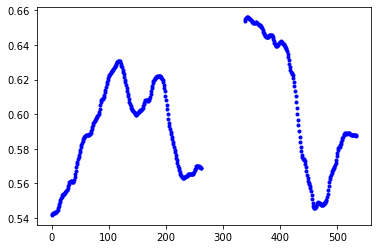

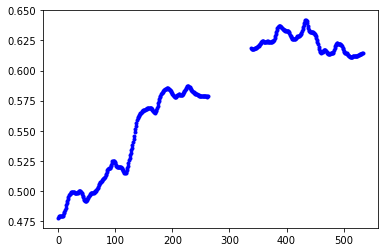

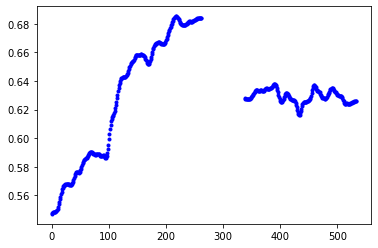

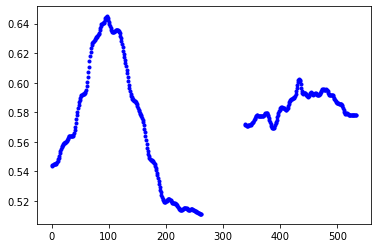

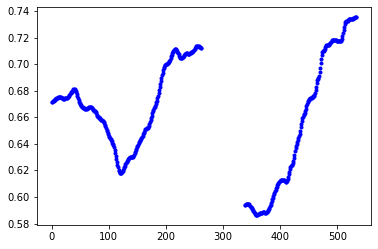

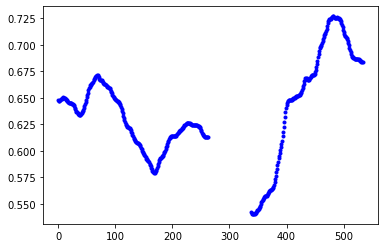

In [10]:
full_data = np.concatenate((pre_data_scaled, data_miss, post_data_scaled), axis=1)
for i in range(len(full_data)):
    plt.figure(i)
    plt.plot(full_data[i,:],'b.')

In [11]:
input_len = 150
output_len = 150

L1 = pre_data_scaled.shape[1] - input_len
print(L1)
L2 = post_data_scaled.shape[1] - input_len
print(L2)
    
train_len = int(0.75 * L1)

X_pre = np.zeros([L1-1, input_len])
Y_pre = np.zeros([L1-1, output_len])
    
X_post = np.zeros([L2-1, input_len])
Y_post = np.zeros([L2-1, output_len])

for i in range(L1-1):
    X_pre[i,:] = pre_data_scaled[0, i:i+input_len]
    Y_pre[i,:] = pre_data_scaled[0, i+1:i+1+output_len]

Train_X_pre = X_pre[:train_len]
Val_X_pre = X_pre[train_len:]

Train_Y_pre = Y_pre[:train_len]
Val_Y_pre = Y_pre[train_len:]

for i in range(L2-1):
    X_post[i,:] = post_data_scaled[0,i:i+input_len]
    Y_post[i,:] = post_data_scaled[0,i+1:i+1+output_len]

Train_X_post = X_post[:train_len]
Val_X_post = X_post[train_len:]

Train_Y_post = Y_post[:train_len]
Val_Y_post = Y_post[train_len:]

Train_X_Cumulative = np.append(Train_X_pre, Train_X_post, axis=0)
Train_Y_Cumulative = np.append(Train_Y_pre, Train_Y_post, axis=0)
Val_X_Cumulative = np.append(Val_X_pre, Val_X_post, axis=0)
Val_Y_Cumulative = np.append(Val_Y_pre, Val_Y_post, axis=0)

113
46


In [12]:
print(Val_X_Cumulative[0])
print(Val_Y_Cumulative[0])

[0.55033903 0.54827346 0.54630158 0.54468076 0.54359378 0.54292513
 0.54246334 0.54191136 0.54104665 0.54003021 0.53911894 0.53856971
 0.53857691 0.53908485 0.53997535 0.5411302  0.54243122 0.54376021
 0.54499897 0.54602931 0.54673304 0.54703737 0.54705116 0.54692868
 0.5468242  0.54689199 0.54724715 0.54784815 0.54861428 0.54946483
 0.55031911 0.55109642 0.55171605 0.5520973  0.55215946 0.55185273
 0.55125081 0.55045833 0.54957988 0.54872007 0.5479835  0.5474748
 0.54729855 0.54752164 0.54806004 0.54879198 0.5495957  0.55034943
 0.55095628 0.55141877 0.55176429 0.55202023 0.55221397 0.5523729
 0.55252442 0.552676   0.55275555 0.55267106 0.55240479 0.55223599
 0.5524221  0.55283632 0.55325579 0.55345763 0.55328085 0.55281194
 0.55219928 0.55159124 0.55110139 0.55070412 0.55033906 0.54994578
 0.54948392 0.54899314 0.54853314 0.54814095 0.54776302 0.54732312
 0.54674503 0.54595255 0.54486945 0.54345775 0.54183241 0.54014661
 0.53855356 0.53720643 0.53625842 0.53582251 0.53585086 0.536255

In [13]:
Train_Y_Cumulative.shape

(129, 150)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim,  output_dim, dropout_prob, hidden_dim, layer_dim):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.d_prob = dropout_prob

        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        
        # Dropout Layer
        self.dropout = nn.Dropout(self.d_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = out[:, -1, :]
        
        out = self.dropout(out)

        out = self.fc(out)

        return out

In [15]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.
    """
    def __init__(self, model, loss_fn, optimizer, patience, min_delta = 1e-8):

        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.counter = 0
        self.min_delta = min_delta
        self.min_validation_loss = np.inf
        self.patience = patience
        
    def train_step(self, x, y):

        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def earlyStop(self, validation_loss):
        if validation_loss < (self.min_validation_loss - self.min_delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
            
        elif validation_loss >= (self.min_validation_loss - self.min_delta):
            self.counter +=1
            if self.counter >= self.patience:
                return True
            return False

    def train(self, train_loader, val_loader, batch_size, n_epochs, mode, n_features, output_dim):

        model_path = f'lstm_seq_mode_{mode}.pt'
        break_out_flag = False

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                if self.earlyStop(validation_loss):
                    break_out_flag = True
                    break               
            
            if break_out_flag:
                torch.save(self.model.state_dict(), model_path)
                break

            if (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
        torch.save(self.model.state_dict(), model_path)
          
    def evaluate(self, x, test, training_len, output_len, missing_len):
        with torch.no_grad():
            predictions = []
            values = []
            for j in range(len(test)):
                val = test[j].to(device).cpu()
                values.append(val.detach().numpy())
            
            for i in range(missing_len):
                x = x.to(device)
                self.model.eval()
                x_test = x.view([1, -1, training_len]).to(device)
                #print(x_test)
                yhat = self.model(x_test)
                #print(yhat)
                
                yint = torch.reshape(yhat,(output_len,1))                
                y_int = yint.to(device).cpu()
                predictions.append(y_int[-1].detach().numpy())
                #print(predictions)
                x = torch.reshape(x,(training_len,1))
                x = torch.cat((x,yint[-1].reshape(1,1)),0)
                x = x[-training_len:]
                #print(x)
                
            #num = len(test) % missing_len
            #if (num == 0):
            #    for i in range(math.floor(len(test)/missing_len)):
            #        x = x.to(device)
            #        self.model.eval()
            #        x_test = x.view([1, -1, training_len]).to(device)
                
            #        yhat = self.model(x_test)
            #        yint = torch.reshape(yhat,(missing_len,1))                
            #        y_int = yint.to(device).cpu()
            #        predictions.append(y_int.detach().numpy())
            #        x = torch.reshape(x,(training_len,1))
            #        x = torch.cat((x,yint),0)
            #        x = x[-training_len:]
            #else:
            #    for i in range(math.floor(len(test)/missing_len)+1):
            #        x = x.to(device)
            #        self.model.eval()
            #        x_test = x.view([1, -1, training_len]).to(device)
                
            #        yhat = self.model(x_test)
            #        yint = torch.reshape(yhat,(missing_len,1))                
            #        y_int = yint.to(device).cpu()
            #        predictions.append(y_int.detach().numpy())
            #        x = torch.reshape(x,(training_len,1))
            #        x = torch.cat((x,yint),0)
            #        x = x[-training_len:]
            
        preds =  torch.reshape(torch.Tensor(predictions),(-1,1))
        
        return np.asarray(values), np.asarray(preds)



    def plot_losses(self, training_len):
        """The method plots the calculated loss values for training and validation
        """
        np.savetxt(f"Output_length={training_len}_train.out", self.train_losses, fmt='%1.4e')
        np.savetxt(f"Output_length={training_len}_val.out", self.val_losses, fmt='%1.4e')
        
        plt.figure(figsize=[10,8])
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title(f"Losses for output length = {training_len}")
        plt.grid()
        plt.show()
        plt.savefig(f'Losses comparisons for output length={training_len} over epochs.png',dpi=300)
        plt.close()

In [16]:
def get_model(model, model_params):
    models = {
        #"rnn": RNNModel,
        "lstm": LSTMModel,
        #"bi-lstm": BiLSTMModel,
        #"gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [17]:
input_dim = input_len
output_dim = output_len
hidden_dim = 32
layer_dim = 2
dropout = 0.3
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
class SquareRootLoss(nn.Module):
    def __init__(self):
        super(SquareRootLoss, self).__init__()
        
    def forward(self, output, target):
        loss = torch.mean(torch.sqrt(abs(output-target)))
        return loss

In [19]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, output, target):
        Loss = torch.zeros([output.shape[0], output.shape[1]])
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if (abs(output[i][j]-target[i][j]) < 0.5):
                    Loss[i][j] = 4 * (output[i][j]-target[i][j])**2
                else:
                    Loss[i][j] = 1
        loss = torch.mean(Loss)
        return loss

In [20]:
class MeanCubeLoss(nn.Module):
    def __init__(self):
        super(MeanCubeLoss, self).__init__()
        
    def forward(self, output, target):
        loss = torch.mean(abs(output-target)**3)
        return loss

[50/3000] Training loss: 0.2202	 Validation loss: 0.2168
[100/3000] Training loss: 0.0711	 Validation loss: 0.0460
[150/3000] Training loss: 0.0347	 Validation loss: 0.0095
[200/3000] Training loss: 0.0259	 Validation loss: 0.0033
[250/3000] Training loss: 0.0221	 Validation loss: 0.0020
[300/3000] Training loss: 0.0203	 Validation loss: 0.0015
[350/3000] Training loss: 0.0175	 Validation loss: 0.0013
[400/3000] Training loss: 0.0177	 Validation loss: 0.0011
[450/3000] Training loss: 0.0162	 Validation loss: 0.0011


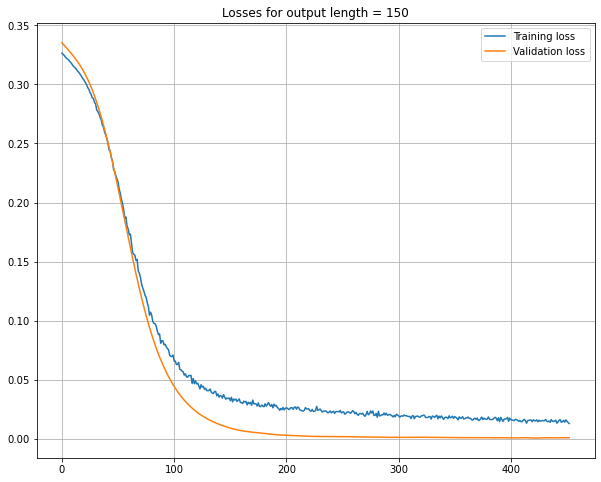

The total duration for the training is 0.13072920000000002 minutes
[50/3000] Training loss: 0.1855	 Validation loss: 0.1768
[100/3000] Training loss: 0.0603	 Validation loss: 0.0377
[150/3000] Training loss: 0.0320	 Validation loss: 0.0090
[200/3000] Training loss: 0.0221	 Validation loss: 0.0042
[250/3000] Training loss: 0.0190	 Validation loss: 0.0031
[300/3000] Training loss: 0.0191	 Validation loss: 0.0026
[350/3000] Training loss: 0.0153	 Validation loss: 0.0024
[400/3000] Training loss: 0.0151	 Validation loss: 0.0022
[450/3000] Training loss: 0.0153	 Validation loss: 0.0021
[500/3000] Training loss: 0.0120	 Validation loss: 0.0020
[550/3000] Training loss: 0.0112	 Validation loss: 0.0017


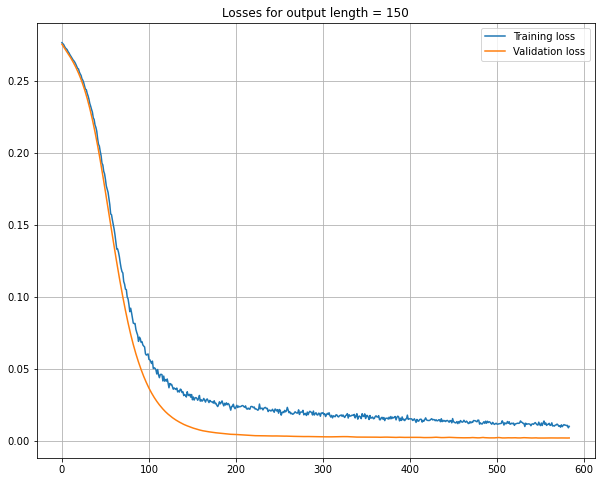

The total duration for the training is 0.10832279500000001 minutes
[50/3000] Training loss: 0.2818	 Validation loss: 0.2525
[100/3000] Training loss: 0.0922	 Validation loss: 0.0562
[150/3000] Training loss: 0.0425	 Validation loss: 0.0129
[200/3000] Training loss: 0.0345	 Validation loss: 0.0050
[250/3000] Training loss: 0.0268	 Validation loss: 0.0033
[300/3000] Training loss: 0.0256	 Validation loss: 0.0029
[350/3000] Training loss: 0.0235	 Validation loss: 0.0028
[400/3000] Training loss: 0.0238	 Validation loss: 0.0027
[450/3000] Training loss: 0.0221	 Validation loss: 0.0027
[500/3000] Training loss: 0.0177	 Validation loss: 0.0027
[550/3000] Training loss: 0.0164	 Validation loss: 0.0028
[600/3000] Training loss: 0.0153	 Validation loss: 0.0028
[650/3000] Training loss: 0.0139	 Validation loss: 0.0027


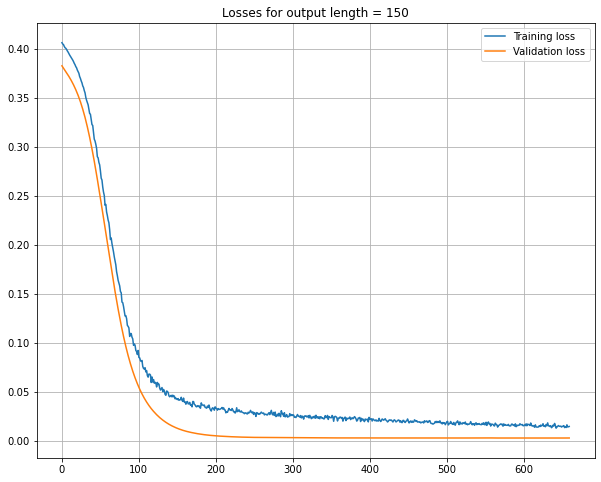

The total duration for the training is 0.12550586 minutes
[50/3000] Training loss: 0.3431	 Validation loss: 0.5329
[100/3000] Training loss: 0.1213	 Validation loss: 0.1673
[150/3000] Training loss: 0.0632	 Validation loss: 0.0652
[200/3000] Training loss: 0.0494	 Validation loss: 0.0465
[250/3000] Training loss: 0.0414	 Validation loss: 0.0404
[300/3000] Training loss: 0.0402	 Validation loss: 0.0329
[350/3000] Training loss: 0.0338	 Validation loss: 0.0269
[400/3000] Training loss: 0.0344	 Validation loss: 0.0219
[450/3000] Training loss: 0.0360	 Validation loss: 0.0201
[500/3000] Training loss: 0.0309	 Validation loss: 0.0194


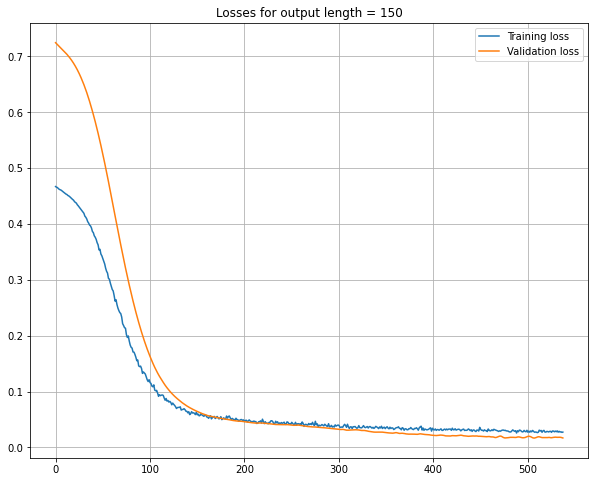

The total duration for the training is 0.1058529783333333 minutes
[50/3000] Training loss: 0.4224	 Validation loss: 0.3067
[100/3000] Training loss: 0.1488	 Validation loss: 0.0745
[150/3000] Training loss: 0.0671	 Validation loss: 0.0202
[200/3000] Training loss: 0.0512	 Validation loss: 0.0104
[250/3000] Training loss: 0.0408	 Validation loss: 0.0085
[300/3000] Training loss: 0.0396	 Validation loss: 0.0078


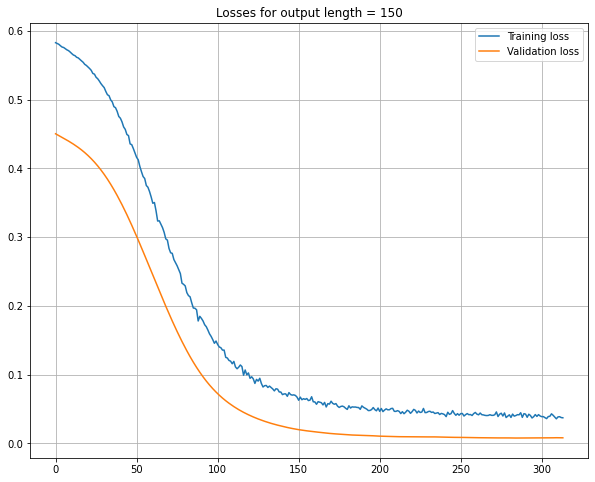

The total duration for the training is 0.0810000683333333 minutes
[50/3000] Training loss: 0.2710	 Validation loss: 0.2376
[100/3000] Training loss: 0.0895	 Validation loss: 0.0515
[150/3000] Training loss: 0.0424	 Validation loss: 0.0111
[200/3000] Training loss: 0.0320	 Validation loss: 0.0041
[250/3000] Training loss: 0.0274	 Validation loss: 0.0027
[300/3000] Training loss: 0.0261	 Validation loss: 0.0024
[350/3000] Training loss: 0.0224	 Validation loss: 0.0023
[400/3000] Training loss: 0.0232	 Validation loss: 0.0023
[450/3000] Training loss: 0.0211	 Validation loss: 0.0022
[500/3000] Training loss: 0.0188	 Validation loss: 0.0021
[550/3000] Training loss: 0.0156	 Validation loss: 0.0022


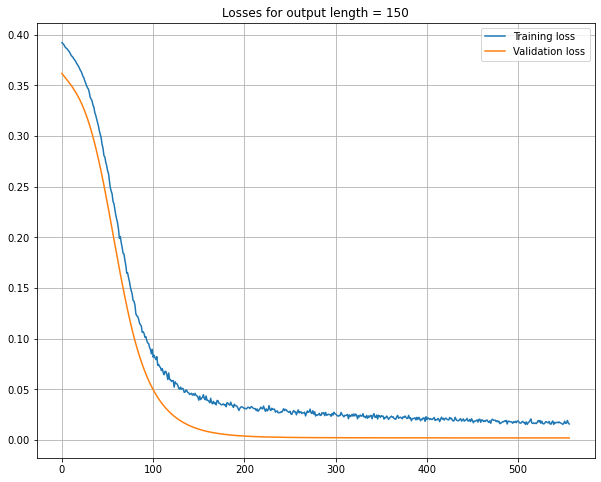

The total duration for the training is 0.1253577283333333 minutes
[50/3000] Training loss: 0.3674	 Validation loss: 0.3800
[100/3000] Training loss: 0.1218	 Validation loss: 0.0938
[150/3000] Training loss: 0.0554	 Validation loss: 0.0204
[200/3000] Training loss: 0.0382	 Validation loss: 0.0072
[250/3000] Training loss: 0.0339	 Validation loss: 0.0045
[300/3000] Training loss: 0.0324	 Validation loss: 0.0037


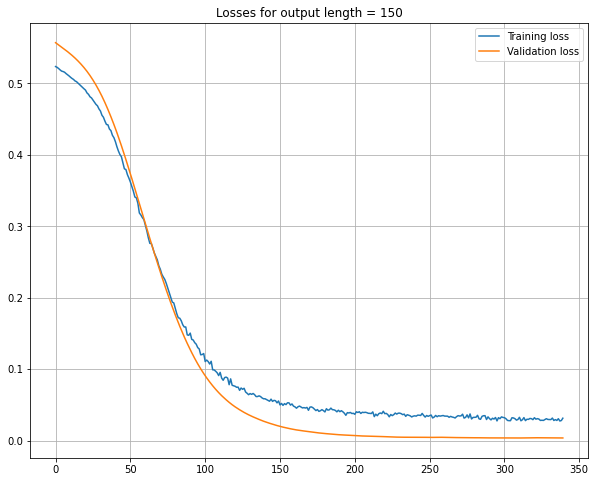

The total duration for the training is 0.0677571816666666 minutes
[50/3000] Training loss: 0.3411	 Validation loss: 0.3049
[100/3000] Training loss: 0.1117	 Validation loss: 0.0714
[150/3000] Training loss: 0.0485	 Validation loss: 0.0150
[200/3000] Training loss: 0.0374	 Validation loss: 0.0048
[250/3000] Training loss: 0.0307	 Validation loss: 0.0027
[300/3000] Training loss: 0.0299	 Validation loss: 0.0022
[350/3000] Training loss: 0.0281	 Validation loss: 0.0020
[400/3000] Training loss: 0.0279	 Validation loss: 0.0019


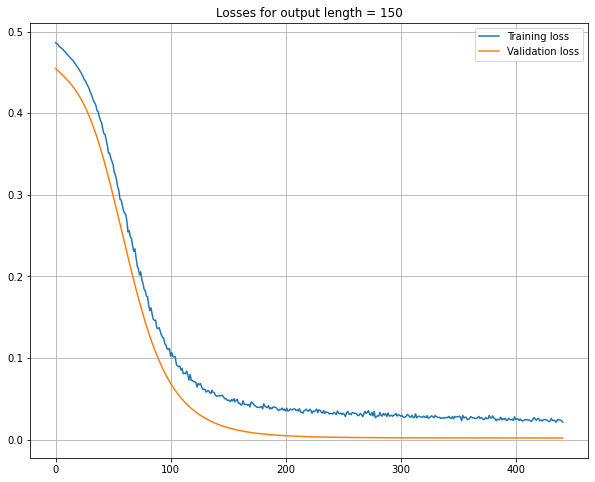

The total duration for the training is 0.08128246166666671 minutes
[50/3000] Training loss: 0.2468	 Validation loss: 0.2941
[100/3000] Training loss: 0.0801	 Validation loss: 0.0711
[150/3000] Training loss: 0.0399	 Validation loss: 0.0178
[200/3000] Training loss: 0.0282	 Validation loss: 0.0086
[250/3000] Training loss: 0.0242	 Validation loss: 0.0063
[300/3000] Training loss: 0.0227	 Validation loss: 0.0056
[350/3000] Training loss: 0.0209	 Validation loss: 0.0050
[400/3000] Training loss: 0.0193	 Validation loss: 0.0045
[450/3000] Training loss: 0.0208	 Validation loss: 0.0043


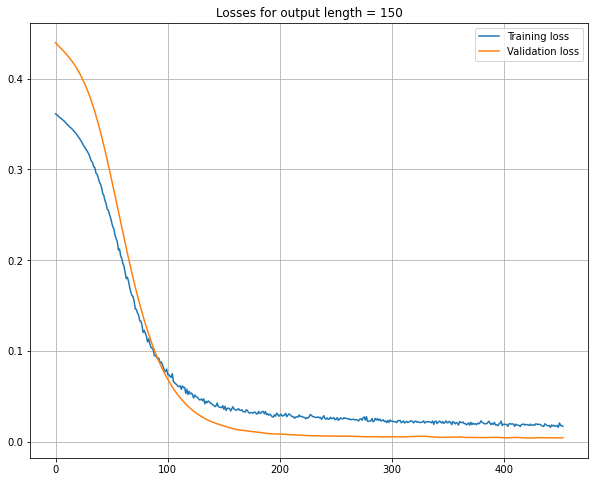

The total duration for the training is 0.08409198000000005 minutes
[50/3000] Training loss: 0.2683	 Validation loss: 0.2121
[100/3000] Training loss: 0.0895	 Validation loss: 0.0452
[150/3000] Training loss: 0.0446	 Validation loss: 0.0104
[200/3000] Training loss: 0.0334	 Validation loss: 0.0047
[250/3000] Training loss: 0.0296	 Validation loss: 0.0037
[300/3000] Training loss: 0.0259	 Validation loss: 0.0034
[350/3000] Training loss: 0.0232	 Validation loss: 0.0034
[400/3000] Training loss: 0.0245	 Validation loss: 0.0032


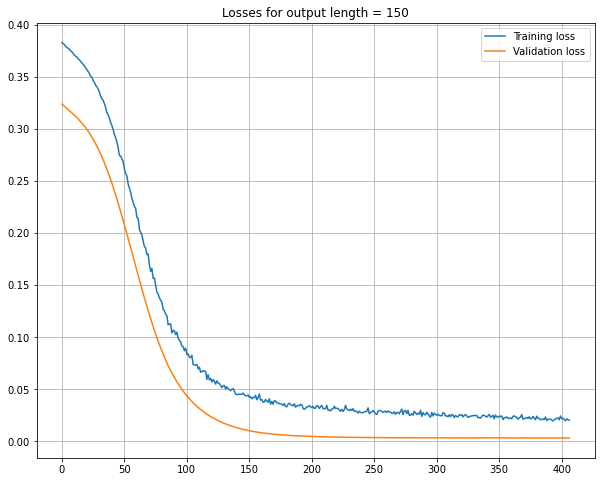

The total duration for the training is 0.07901122999999993 minutes
[50/3000] Training loss: 0.4221	 Validation loss: 0.4396
[100/3000] Training loss: 0.1377	 Validation loss: 0.1120
[150/3000] Training loss: 0.0585	 Validation loss: 0.0242
[200/3000] Training loss: 0.0432	 Validation loss: 0.0074
[250/3000] Training loss: 0.0367	 Validation loss: 0.0036
[300/3000] Training loss: 0.0347	 Validation loss: 0.0029
[350/3000] Training loss: 0.0290	 Validation loss: 0.0024


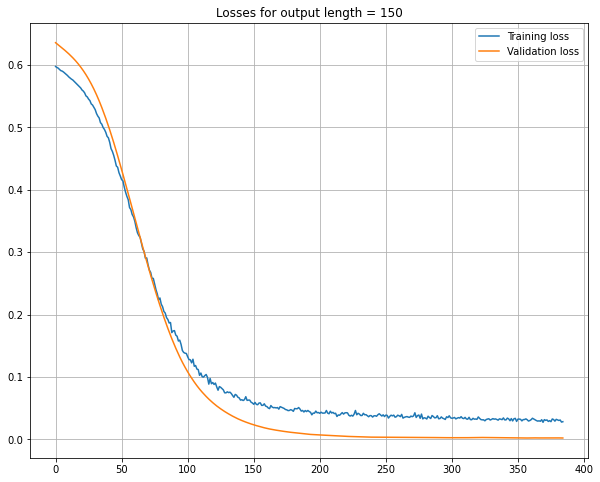

The total duration for the training is 0.08661919666666668 minutes
[50/3000] Training loss: 0.3889	 Validation loss: 0.3106
[100/3000] Training loss: 0.1342	 Validation loss: 0.0732
[150/3000] Training loss: 0.0592	 Validation loss: 0.0163
[200/3000] Training loss: 0.0421	 Validation loss: 0.0058
[250/3000] Training loss: 0.0384	 Validation loss: 0.0039
[300/3000] Training loss: 0.0338	 Validation loss: 0.0034
[350/3000] Training loss: 0.0281	 Validation loss: 0.0033


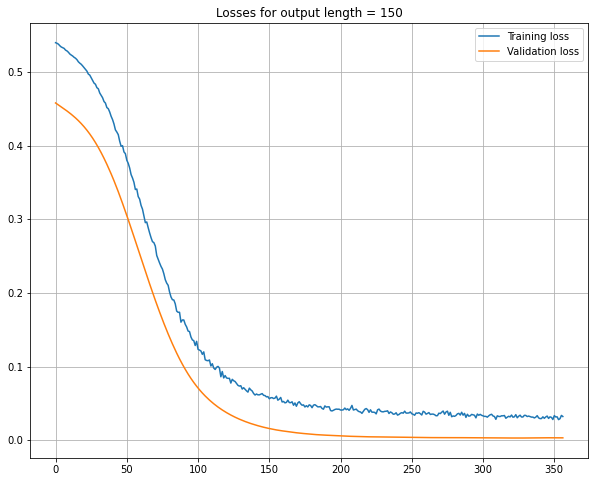

The total duration for the training is 0.07676576499999992 minutes
[50/3000] Training loss: 0.2427	 Validation loss: 0.2416
[100/3000] Training loss: 0.0767	 Validation loss: 0.0521
[150/3000] Training loss: 0.0389	 Validation loss: 0.0104
[200/3000] Training loss: 0.0274	 Validation loss: 0.0034
[250/3000] Training loss: 0.0236	 Validation loss: 0.0018
[300/3000] Training loss: 0.0226	 Validation loss: 0.0013


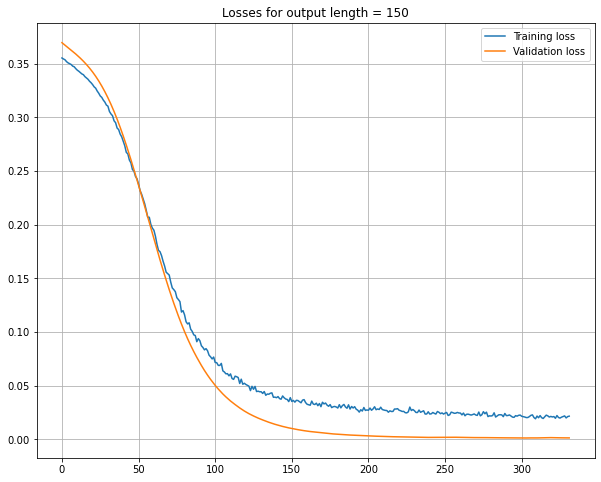

The total duration for the training is 0.06681489833333316 minutes
[50/3000] Training loss: 0.3001	 Validation loss: 0.2786
[100/3000] Training loss: 0.0972	 Validation loss: 0.0618
[150/3000] Training loss: 0.0451	 Validation loss: 0.0126
[200/3000] Training loss: 0.0342	 Validation loss: 0.0034
[250/3000] Training loss: 0.0285	 Validation loss: 0.0015
[300/3000] Training loss: 0.0265	 Validation loss: 0.0010


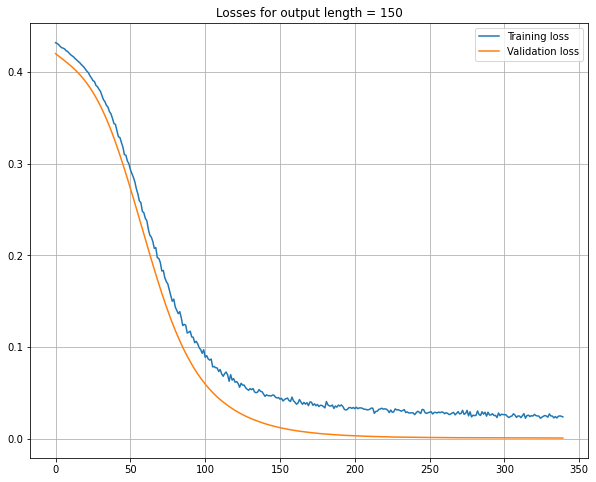

The total duration for the training is 0.06252559833333346 minutes
[50/3000] Training loss: 0.2821	 Validation loss: 0.3042
[100/3000] Training loss: 0.0917	 Validation loss: 0.0719
[150/3000] Training loss: 0.0433	 Validation loss: 0.0172
[200/3000] Training loss: 0.0322	 Validation loss: 0.0079
[250/3000] Training loss: 0.0294	 Validation loss: 0.0058
[300/3000] Training loss: 0.0262	 Validation loss: 0.0051


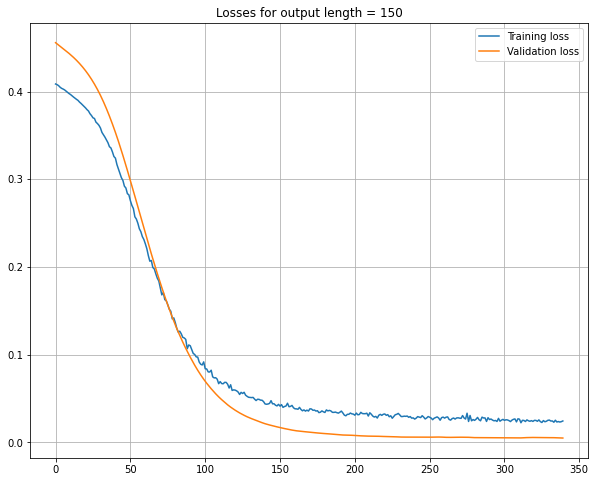

The total duration for the training is 0.0629326216666667 minutes
[50/3000] Training loss: 0.2807	 Validation loss: 0.3228
[100/3000] Training loss: 0.0923	 Validation loss: 0.0801
[150/3000] Training loss: 0.0420	 Validation loss: 0.0205
[200/3000] Training loss: 0.0318	 Validation loss: 0.0106
[250/3000] Training loss: 0.0289	 Validation loss: 0.0081
[300/3000] Training loss: 0.0247	 Validation loss: 0.0076


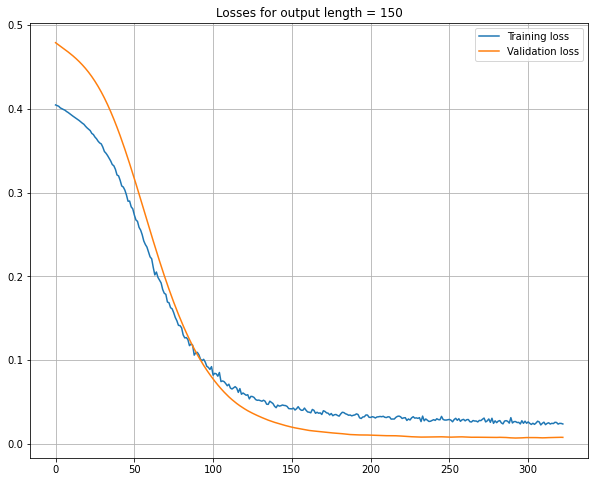

The total duration for the training is 0.05958085833333347 minutes
[50/3000] Training loss: 0.3478	 Validation loss: 0.3415
[100/3000] Training loss: 0.1143	 Validation loss: 0.0798
[150/3000] Training loss: 0.0504	 Validation loss: 0.0161
[200/3000] Training loss: 0.0370	 Validation loss: 0.0045
[250/3000] Training loss: 0.0329	 Validation loss: 0.0023
[300/3000] Training loss: 0.0298	 Validation loss: 0.0016
[350/3000] Training loss: 0.0260	 Validation loss: 0.0013


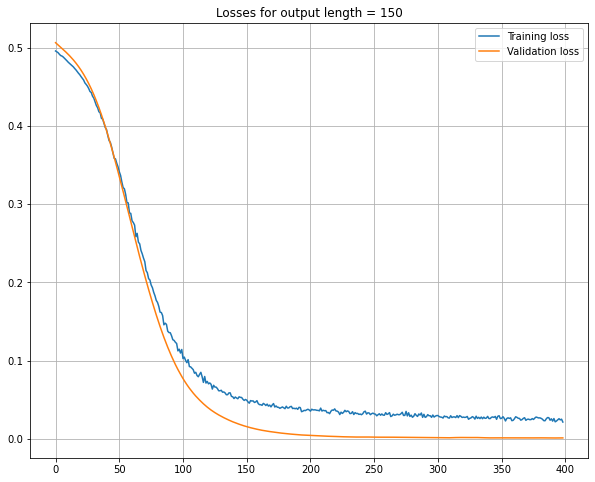

The total duration for the training is 0.0732145683333331 minutes
[50/3000] Training loss: 0.3302	 Validation loss: 0.2935
[100/3000] Training loss: 0.1061	 Validation loss: 0.0674
[150/3000] Training loss: 0.0512	 Validation loss: 0.0148
[200/3000] Training loss: 0.0368	 Validation loss: 0.0049
[250/3000] Training loss: 0.0322	 Validation loss: 0.0029
[300/3000] Training loss: 0.0293	 Validation loss: 0.0024
[350/3000] Training loss: 0.0268	 Validation loss: 0.0023
[400/3000] Training loss: 0.0271	 Validation loss: 0.0022
[450/3000] Training loss: 0.0259	 Validation loss: 0.0022


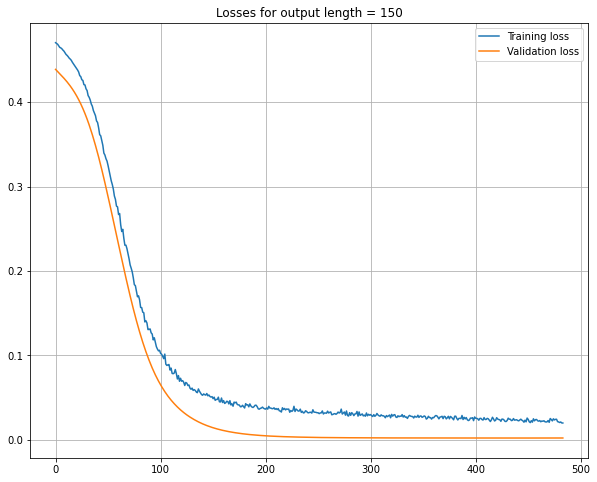

The total duration for the training is 0.08920403833333333 minutes
[50/3000] Training loss: 0.2451	 Validation loss: 0.1995
[100/3000] Training loss: 0.0828	 Validation loss: 0.0474
[150/3000] Training loss: 0.0427	 Validation loss: 0.0152
[200/3000] Training loss: 0.0312	 Validation loss: 0.0091
[250/3000] Training loss: 0.0268	 Validation loss: 0.0075
[300/3000] Training loss: 0.0261	 Validation loss: 0.0065
[350/3000] Training loss: 0.0206	 Validation loss: 0.0054
[400/3000] Training loss: 0.0229	 Validation loss: 0.0047
[450/3000] Training loss: 0.0210	 Validation loss: 0.0042
[500/3000] Training loss: 0.0180	 Validation loss: 0.0040
[550/3000] Training loss: 0.0161	 Validation loss: 0.0036
[600/3000] Training loss: 0.0145	 Validation loss: 0.0035
[650/3000] Training loss: 0.0148	 Validation loss: 0.0034


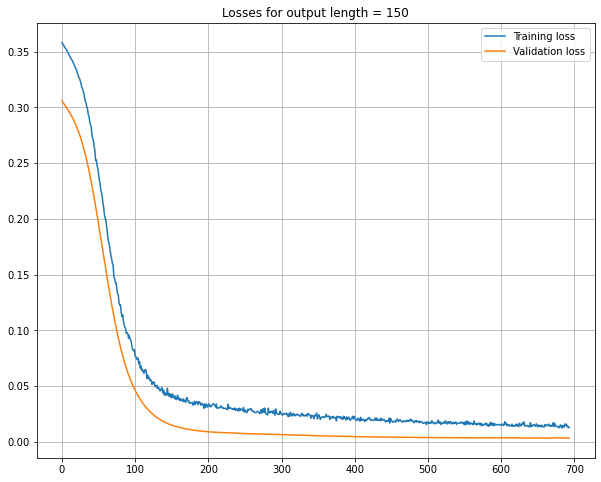

The total duration for the training is 0.1245208816666666 minutes
[50/3000] Training loss: 0.1212	 Validation loss: 0.0792
[100/3000] Training loss: 0.0612	 Validation loss: 0.0403
[150/3000] Training loss: 0.0359	 Validation loss: 0.0229
[200/3000] Training loss: 0.0238	 Validation loss: 0.0154
[250/3000] Training loss: 0.0194	 Validation loss: 0.0119
[300/3000] Training loss: 0.0191	 Validation loss: 0.0100
[350/3000] Training loss: 0.0164	 Validation loss: 0.0087
[400/3000] Training loss: 0.0161	 Validation loss: 0.0075
[450/3000] Training loss: 0.0148	 Validation loss: 0.0065
[500/3000] Training loss: 0.0118	 Validation loss: 0.0055
[550/3000] Training loss: 0.0110	 Validation loss: 0.0048
[600/3000] Training loss: 0.0096	 Validation loss: 0.0041
[650/3000] Training loss: 0.0091	 Validation loss: 0.0038
[700/3000] Training loss: 0.0090	 Validation loss: 0.0035
[750/3000] Training loss: 0.0081	 Validation loss: 0.0033


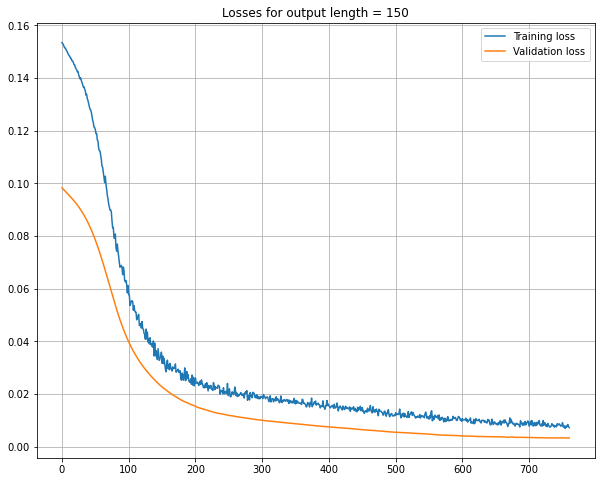

The total duration for the training is 0.189128645 minutes
[50/3000] Training loss: 0.5370	 Validation loss: 0.4406
[100/3000] Training loss: 0.1885	 Validation loss: 0.1140
[150/3000] Training loss: 0.0752	 Validation loss: 0.0262
[200/3000] Training loss: 0.0521	 Validation loss: 0.0090
[250/3000] Training loss: 0.0436	 Validation loss: 0.0054
[300/3000] Training loss: 0.0409	 Validation loss: 0.0045
[350/3000] Training loss: 0.0380	 Validation loss: 0.0044


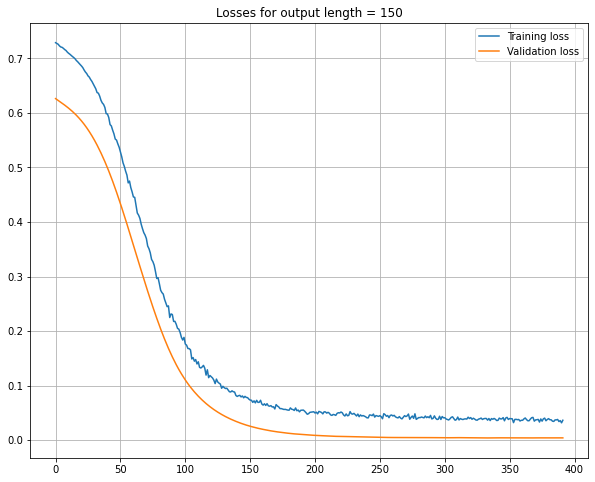

The total duration for the training is 0.08617181833333329 minutes
[50/3000] Training loss: 0.1506	 Validation loss: 0.1603
[100/3000] Training loss: 0.0484	 Validation loss: 0.0344
[150/3000] Training loss: 0.0295	 Validation loss: 0.0100
[200/3000] Training loss: 0.0198	 Validation loss: 0.0059
[250/3000] Training loss: 0.0163	 Validation loss: 0.0045
[300/3000] Training loss: 0.0157	 Validation loss: 0.0040
[350/3000] Training loss: 0.0143	 Validation loss: 0.0035
[400/3000] Training loss: 0.0134	 Validation loss: 0.0029


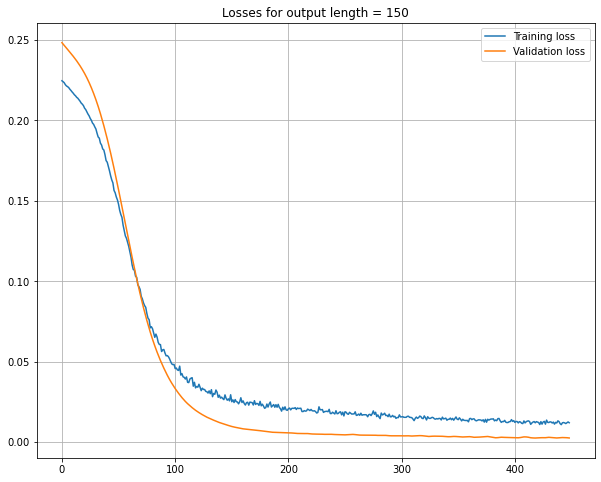

The total duration for the training is 0.09043319499999995 minutes
[50/3000] Training loss: 0.2399	 Validation loss: 0.2566
[100/3000] Training loss: 0.0789	 Validation loss: 0.0622
[150/3000] Training loss: 0.0384	 Validation loss: 0.0190
[200/3000] Training loss: 0.0284	 Validation loss: 0.0117
[250/3000] Training loss: 0.0248	 Validation loss: 0.0101
[300/3000] Training loss: 0.0240	 Validation loss: 0.0097
[350/3000] Training loss: 0.0199	 Validation loss: 0.0092


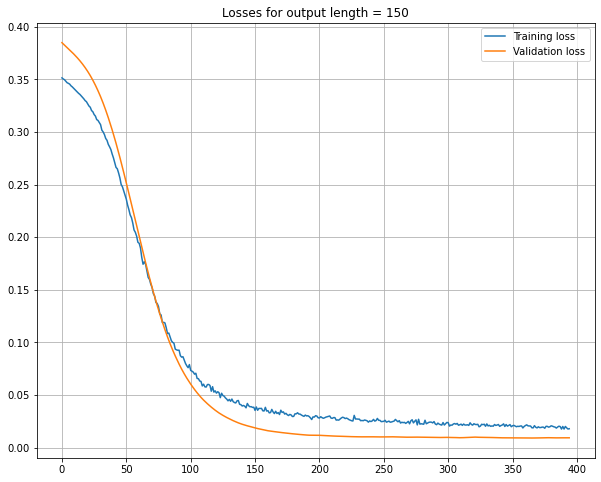

The total duration for the training is 0.07804393666666651 minutes
[50/3000] Training loss: 0.4607	 Validation loss: 0.4463
[100/3000] Training loss: 0.1578	 Validation loss: 0.1185
[150/3000] Training loss: 0.0671	 Validation loss: 0.0277
[200/3000] Training loss: 0.0508	 Validation loss: 0.0102
[250/3000] Training loss: 0.0417	 Validation loss: 0.0059
[300/3000] Training loss: 0.0349	 Validation loss: 0.0038
[350/3000] Training loss: 0.0341	 Validation loss: 0.0025
[400/3000] Training loss: 0.0349	 Validation loss: 0.0015
[450/3000] Training loss: 0.0316	 Validation loss: 0.0018
[500/3000] Training loss: 0.0262	 Validation loss: 0.0019


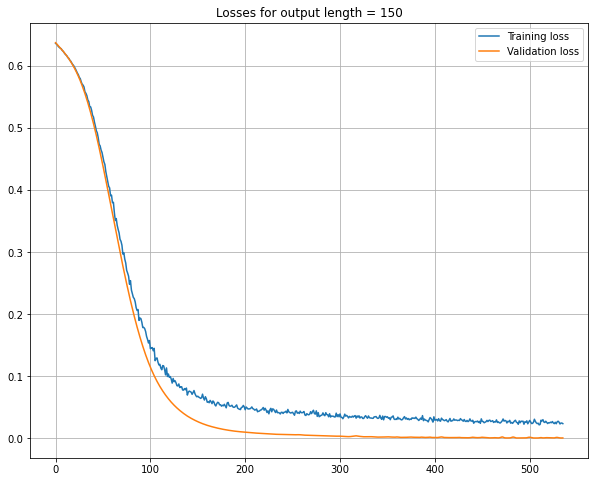

The total duration for the training is 0.10033063666666682 minutes
[50/3000] Training loss: 0.3048	 Validation loss: 0.2768
[100/3000] Training loss: 0.1040	 Validation loss: 0.0684
[150/3000] Training loss: 0.0555	 Validation loss: 0.0203
[200/3000] Training loss: 0.0383	 Validation loss: 0.0108
[250/3000] Training loss: 0.0322	 Validation loss: 0.0081
[300/3000] Training loss: 0.0296	 Validation loss: 0.0064
[350/3000] Training loss: 0.0237	 Validation loss: 0.0047
[400/3000] Training loss: 0.0235	 Validation loss: 0.0034
[450/3000] Training loss: 0.0231	 Validation loss: 0.0029
[500/3000] Training loss: 0.0198	 Validation loss: 0.0024
[550/3000] Training loss: 0.0183	 Validation loss: 0.0017
[600/3000] Training loss: 0.0170	 Validation loss: 0.0015
[650/3000] Training loss: 0.0155	 Validation loss: 0.0016
[700/3000] Training loss: 0.0154	 Validation loss: 0.0016
[750/3000] Training loss: 0.0156	 Validation loss: 0.0013
[800/3000] Training loss: 0.0123	 Validation loss: 0.0013


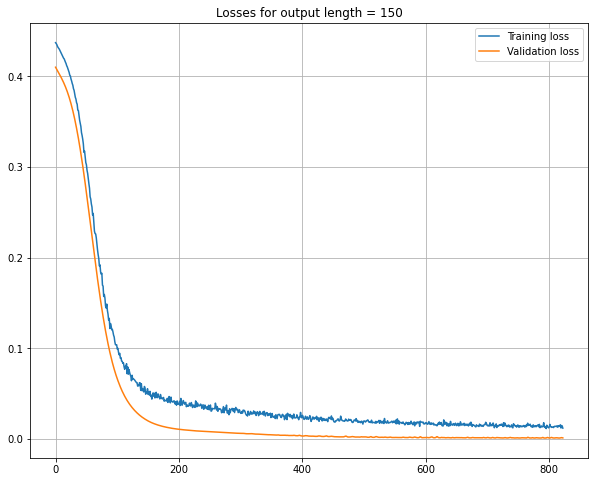

The total duration for the training is 0.1479137316666666 minutes
[50/3000] Training loss: 0.1841	 Validation loss: 0.1666
[100/3000] Training loss: 0.0605	 Validation loss: 0.0363
[150/3000] Training loss: 0.0329	 Validation loss: 0.0095
[200/3000] Training loss: 0.0240	 Validation loss: 0.0048
[250/3000] Training loss: 0.0199	 Validation loss: 0.0034
[300/3000] Training loss: 0.0189	 Validation loss: 0.0026
[350/3000] Training loss: 0.0154	 Validation loss: 0.0019
[400/3000] Training loss: 0.0154	 Validation loss: 0.0013
[450/3000] Training loss: 0.0146	 Validation loss: 0.0012
[500/3000] Training loss: 0.0115	 Validation loss: 0.0012
[550/3000] Training loss: 0.0111	 Validation loss: 0.0009


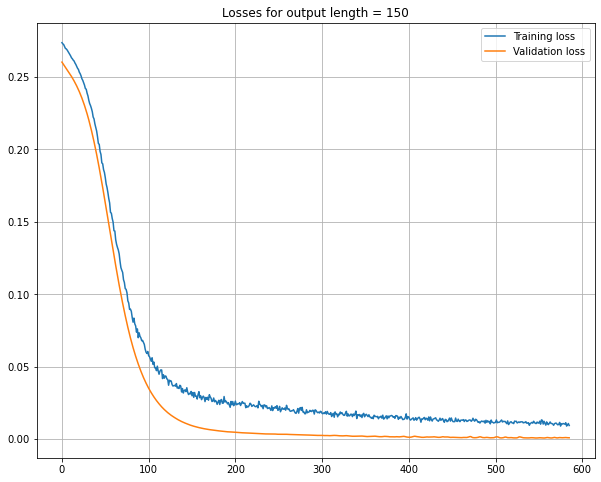

The total duration for the training is 0.1069340950000002 minutes
[50/3000] Training loss: 0.2624	 Validation loss: 0.2687
[100/3000] Training loss: 0.0846	 Validation loss: 0.0597
[150/3000] Training loss: 0.0405	 Validation loss: 0.0126
[200/3000] Training loss: 0.0286	 Validation loss: 0.0046
[250/3000] Training loss: 0.0260	 Validation loss: 0.0028
[300/3000] Training loss: 0.0236	 Validation loss: 0.0023
[350/3000] Training loss: 0.0206	 Validation loss: 0.0021
[400/3000] Training loss: 0.0217	 Validation loss: 0.0020


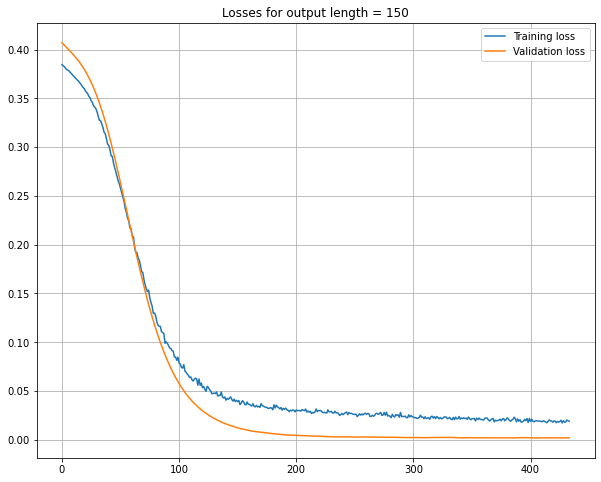

The total duration for the training is 0.08155863666666648 minutes
[50/3000] Training loss: 0.2606	 Validation loss: 0.2442
[100/3000] Training loss: 0.0851	 Validation loss: 0.0552
[150/3000] Training loss: 0.0410	 Validation loss: 0.0107
[200/3000] Training loss: 0.0294	 Validation loss: 0.0032
[250/3000] Training loss: 0.0259	 Validation loss: 0.0016
[300/3000] Training loss: 0.0246	 Validation loss: 0.0013
[350/3000] Training loss: 0.0206	 Validation loss: 0.0010
[400/3000] Training loss: 0.0207	 Validation loss: 0.0009
[450/3000] Training loss: 0.0185	 Validation loss: 0.0009


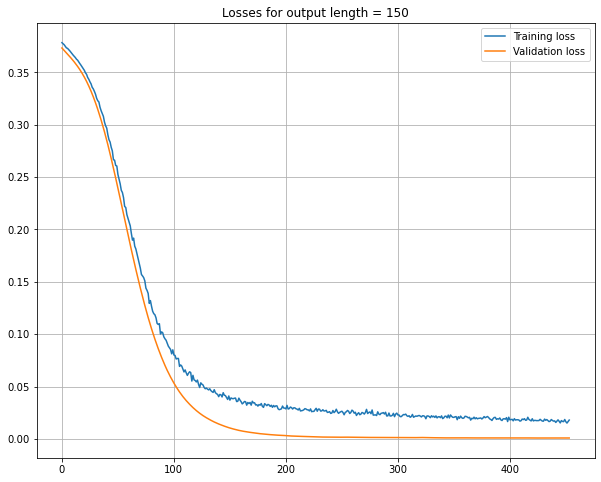

The total duration for the training is 0.08405821499999983 minutes
[50/3000] Training loss: 0.2119	 Validation loss: 0.2204
[100/3000] Training loss: 0.0671	 Validation loss: 0.0469
[150/3000] Training loss: 0.0353	 Validation loss: 0.0098
[200/3000] Training loss: 0.0248	 Validation loss: 0.0039
[250/3000] Training loss: 0.0216	 Validation loss: 0.0027
[300/3000] Training loss: 0.0201	 Validation loss: 0.0021
[350/3000] Training loss: 0.0162	 Validation loss: 0.0019
[400/3000] Training loss: 0.0176	 Validation loss: 0.0017


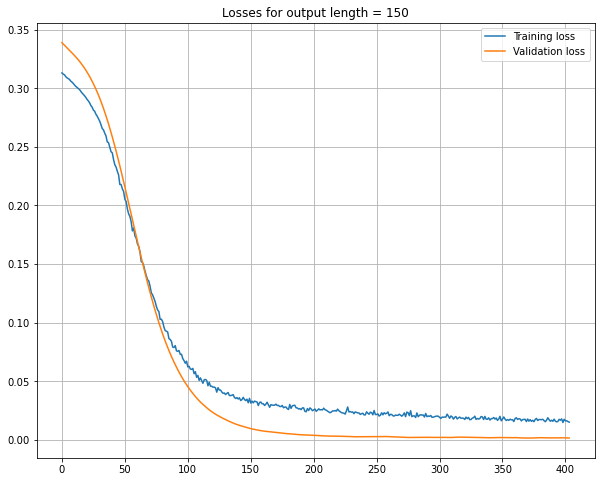

The total duration for the training is 0.07554408333333337 minutes
[50/3000] Training loss: 0.2776	 Validation loss: 0.2924
[100/3000] Training loss: 0.0868	 Validation loss: 0.0659
[150/3000] Training loss: 0.0427	 Validation loss: 0.0138
[200/3000] Training loss: 0.0308	 Validation loss: 0.0050
[250/3000] Training loss: 0.0260	 Validation loss: 0.0026


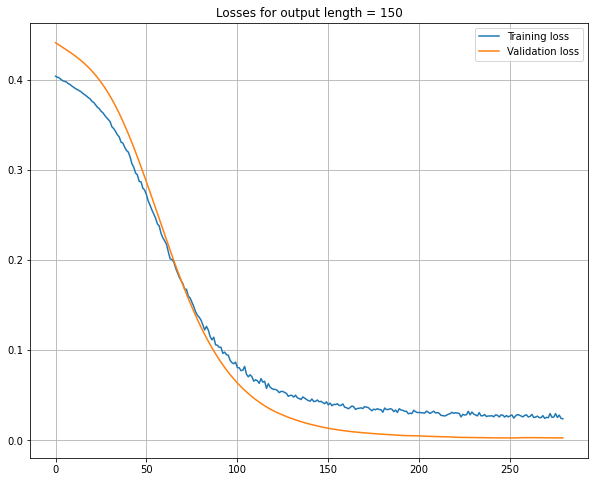

The total duration for the training is 0.05181399166666646 minutes
[50/3000] Training loss: 0.2513	 Validation loss: 0.2153
[100/3000] Training loss: 0.0803	 Validation loss: 0.0461
[150/3000] Training loss: 0.0393	 Validation loss: 0.0097
[200/3000] Training loss: 0.0282	 Validation loss: 0.0033
[250/3000] Training loss: 0.0232	 Validation loss: 0.0020
[300/3000] Training loss: 0.0230	 Validation loss: 0.0017
[350/3000] Training loss: 0.0195	 Validation loss: 0.0016
[400/3000] Training loss: 0.0200	 Validation loss: 0.0016


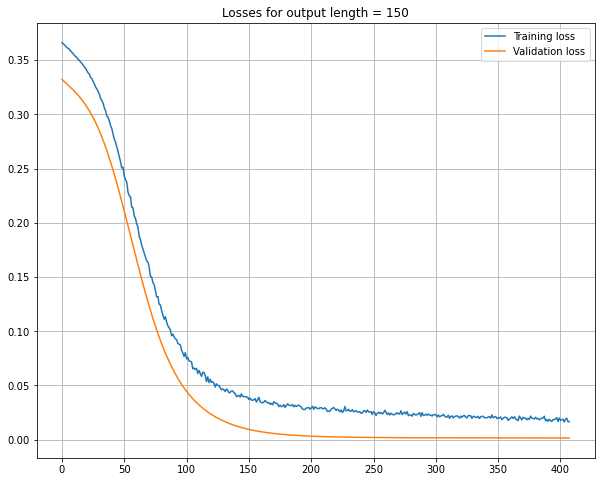

The total duration for the training is 0.07442732833333328 minutes
[50/3000] Training loss: 0.3041	 Validation loss: 0.3065
[100/3000] Training loss: 0.0967	 Validation loss: 0.0705
[150/3000] Training loss: 0.0450	 Validation loss: 0.0142
[200/3000] Training loss: 0.0332	 Validation loss: 0.0046
[250/3000] Training loss: 0.0289	 Validation loss: 0.0027
[300/3000] Training loss: 0.0281	 Validation loss: 0.0024
[350/3000] Training loss: 0.0233	 Validation loss: 0.0020


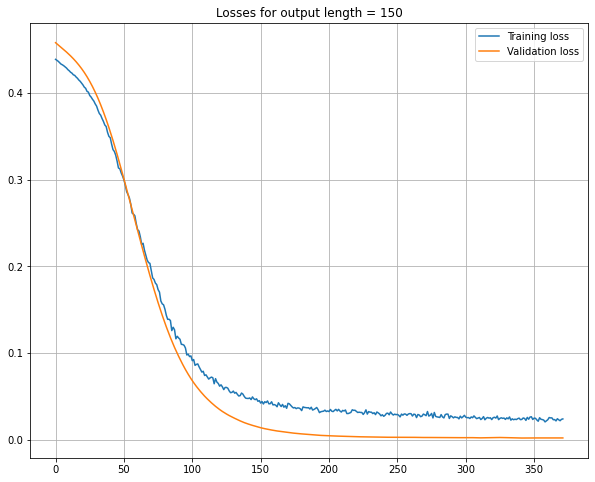

The total duration for the training is 0.06787209000000019 minutes
[50/3000] Training loss: 0.2821	 Validation loss: 0.2614
[100/3000] Training loss: 0.0906	 Validation loss: 0.0574
[150/3000] Training loss: 0.0434	 Validation loss: 0.0117
[200/3000] Training loss: 0.0322	 Validation loss: 0.0036
[250/3000] Training loss: 0.0277	 Validation loss: 0.0019
[300/3000] Training loss: 0.0259	 Validation loss: 0.0015
[350/3000] Training loss: 0.0224	 Validation loss: 0.0013
[400/3000] Training loss: 0.0218	 Validation loss: 0.0012
[450/3000] Training loss: 0.0209	 Validation loss: 0.0012


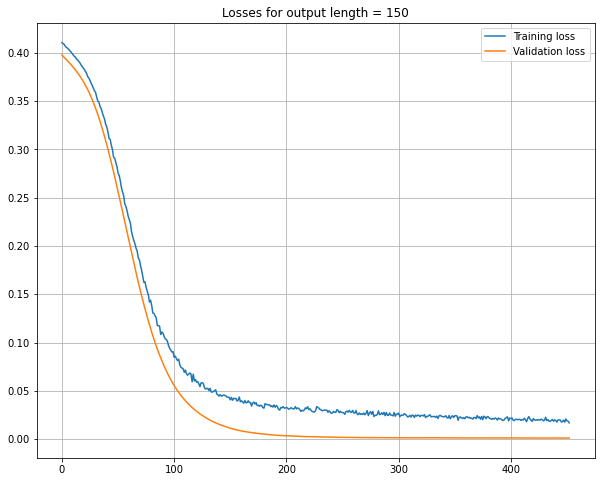

The total duration for the training is 0.09413655166666691 minutes


In [21]:
L1 = pre_data_scaled.shape[1] - input_len
L2 = post_data_scaled.shape[1] - input_len
    
for i in range(len(pre_data_scaled)):
    train_len1 = int(0.75 * L1)
    train_len2 = int(0.75 * L2)

    X_pre = np.zeros([L1-1, input_len])
    Y_pre = np.zeros([L1-1, output_len])
    
    X_post = np.zeros([L2-1, input_len])
    Y_post = np.zeros([L2-1, output_len])

    for j in range(L1-1):
        X_pre[j,:] = pre_data_scaled[i,j:j+input_len]
        Y_pre[j,:] = pre_data_scaled[i,j+1:j+1+input_len]

    Train_X_pre = X_pre[:train_len1]
    Val_X_pre = X_pre[train_len1:]

    Train_Y_pre = Y_pre[:train_len1]
    Val_Y_pre = Y_pre[train_len1:]

    for j in range(L2-1):
        X_post[j,:] = post_data_scaled[i,j:j+input_len]
        Y_post[j,:] = post_data_scaled[i,j+1:j+1+input_len]

    Train_X_post = X_post[:train_len2]
    Val_X_post = X_post[train_len2:]

    Train_Y_post = Y_post[:train_len2]
    Val_Y_post = Y_post[train_len2:]

    Train_X_Cumulative = np.append(Train_X_pre, Train_X_post, axis=0)
    Train_Y_Cumulative = np.append(Train_Y_pre, Train_Y_post, axis=0)
    Val_X_Cumulative = np.append(Val_X_pre, Val_X_post, axis=0)
    Val_Y_Cumulative = np.append(Val_Y_pre, Val_Y_post, axis=0)
    
    mode = i
    
    torch.manual_seed(2)
    
    Train_features = torch.Tensor(Train_X_Cumulative.copy())
    Train_targets = torch.Tensor(Train_Y_Cumulative.copy())
    Val_features = torch.Tensor(Val_X_Cumulative.copy())
    Val_targets = torch.Tensor(Val_Y_Cumulative.copy())

    train_eta = TensorDataset(Train_features, Train_targets)
    val_eta = TensorDataset(Val_features, Val_targets)
    
    start = timer()
    
    model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

    model = get_model('lstm', model_params)
    model = model.to(device)

    batch_size = 32
    n_epochs = 3000

    learning_rate = 1e-4
    loss_fn = nn.MSELoss(reduction="mean")
    #loss_fn = MeanCubeLoss()

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    Ftrain_loader = DataLoader(train_eta, batch_size=batch_size, shuffle=False, drop_last=True)
    Fval_loader = DataLoader(val_eta, batch_size=batch_size, shuffle=False, drop_last=True)
    
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, patience = 30)
    opt.train(Ftrain_loader, Fval_loader, batch_size=batch_size, n_epochs=n_epochs, mode=i, n_features=input_dim, output_dim = output_dim)
    opt.plot_losses(output_dim)
            
    end = timer()

    dur = (end-start)/60
    print(f'The total duration for the training is {dur} minutes')

In [22]:
data_test = scaler.fit_transform(data_whole_vals.reshape(-1,1)).reshape(data_whole_vals.shape[0],data_whole_vals.shape[1])

In [23]:
Predictions = np.zeros([data_miss.shape[0], data_miss.shape[1]])
Values = np.zeros([data_miss.shape[0], data_miss.shape[1]])
missing_len = data_miss.shape[1]

for i in range(len(Predictions)):
    X_Test = np.asarray(data_test[i,data_pre_vals.shape[1]-input_len:data_pre_vals.shape[1]])
    Y_Test = np.asarray(data_test[i,data_pre_vals.shape[1]:data_pre_vals.shape[1]+missing_len])

    Test_features = torch.Tensor(X_Test)
    Test_targets = torch.Tensor(Y_Test)

    model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

    model = get_model('lstm', model_params)
    model = model.to(device)

    PATH = f'lstm_seq_mode_{i}.pt'
    model.load_state_dict(torch.load(PATH))
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    bl1 = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, patience = 50)
    values, preds = bl1.evaluate(Test_features,Test_targets, input_len, output_len, missing_len)
    
    p = np.asarray(preds).reshape(missing_len)
    Predictions[i,:] = p
    Values[i,:] = values

Preds_scaled = scaler.inverse_transform(Predictions.reshape(-1,1))
    
np.savetxt("Pred_All.out", Predictions)
np.savetxt("Vals_All.out", Values)

<ipython-input-15-a743c19ea74b>:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  preds =  torch.reshape(torch.Tensor(predictions),(-1,1))


In [24]:
Predictions

array([[0.49872667, 0.4989565 , 0.49922895, ..., 0.51912624, 0.51946002,
        0.51960218],
       [0.37536475, 0.37555599, 0.37607557, ..., 0.3510361 , 0.35093483,
        0.35058534],
       [0.55680215, 0.55670238, 0.5566147 , ..., 0.56185442, 0.56206459,
        0.56245798],
       ...,
       [0.48134017, 0.48129195, 0.48120761, ..., 0.48773384, 0.48796785,
        0.48812348],
       [0.64345694, 0.64370465, 0.64379537, ..., 0.65698814, 0.65695816,
        0.65693974],
       [0.56181467, 0.56202132, 0.56216377, ..., 0.57614416, 0.57625943,
        0.57610887]])

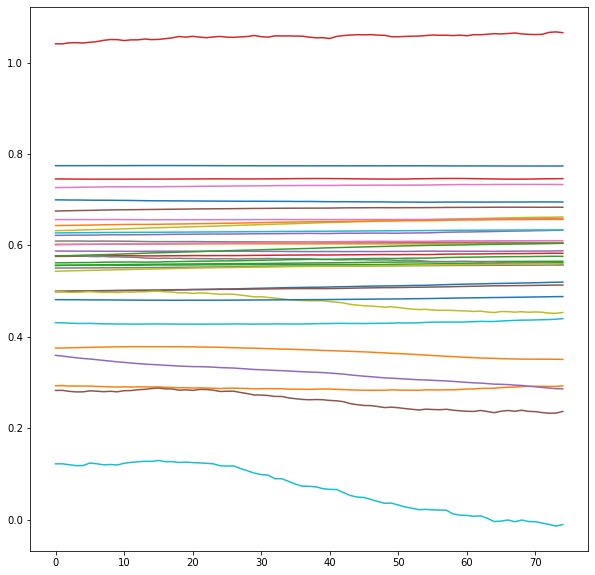

In [25]:
plt.figure(figsize=[10,10])
for i in range(len(Predictions)):
    plt.plot(Predictions[i,:])

In [26]:
Test_targets.shape

torch.Size([75])

<ipython-input-27-6c56d5c62542>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


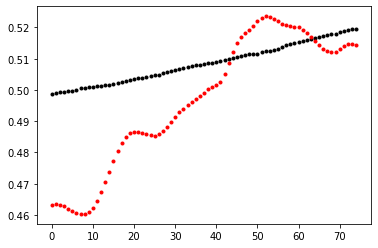

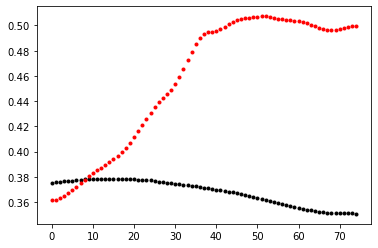

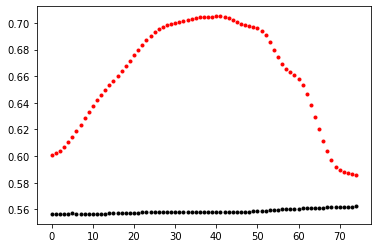

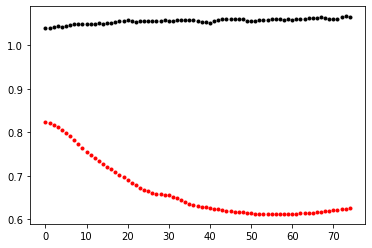

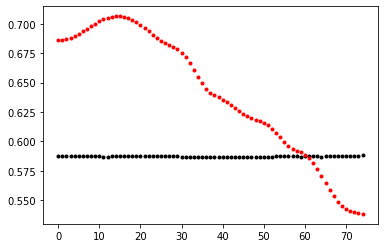

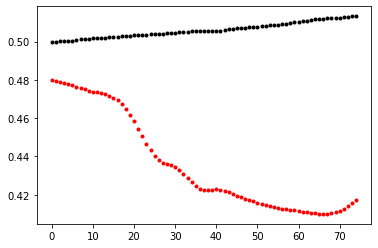

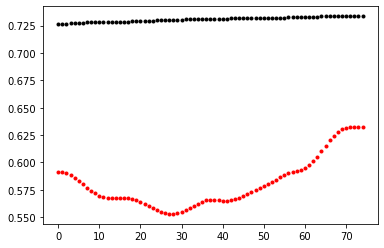

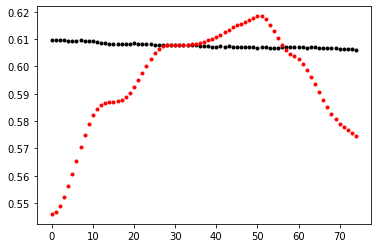

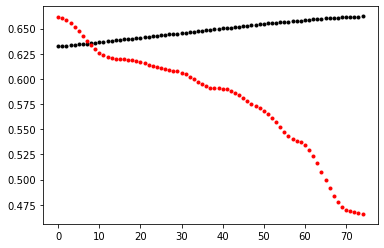

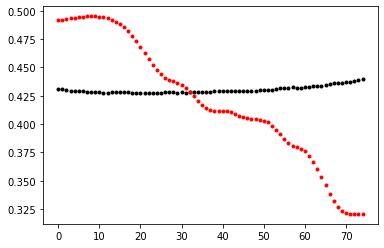

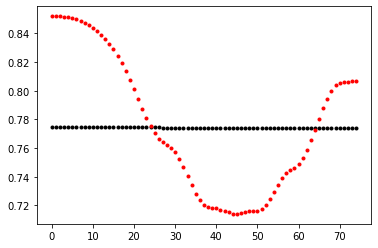

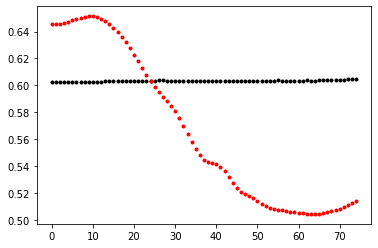

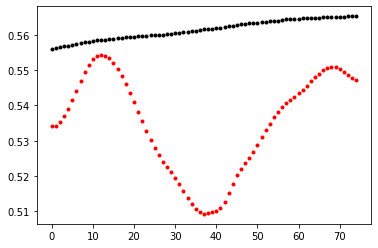

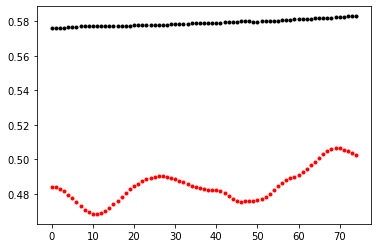

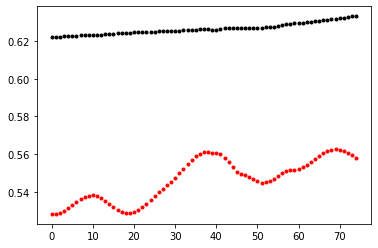

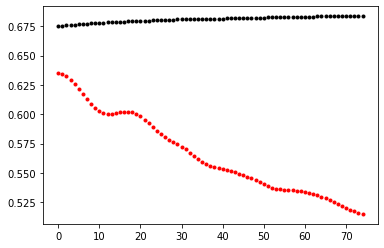

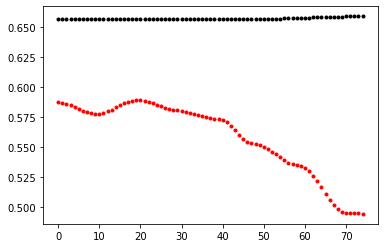

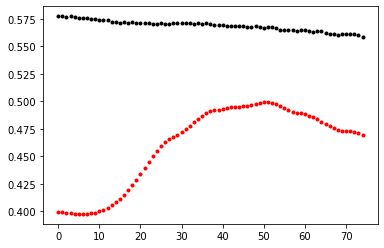

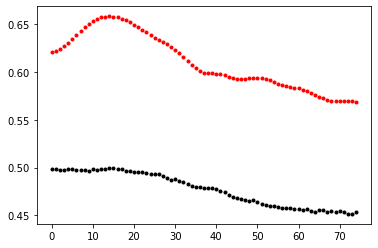

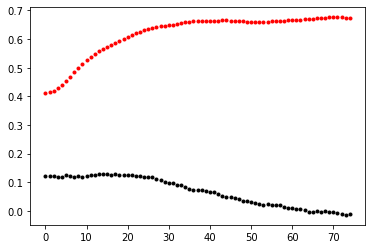

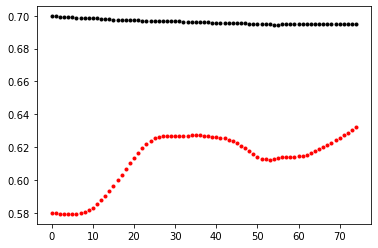

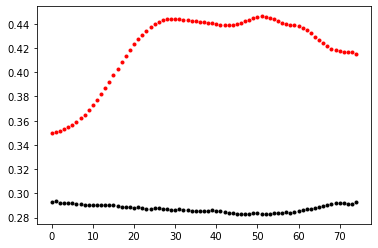

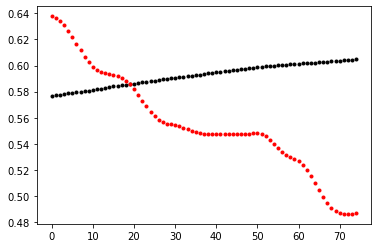

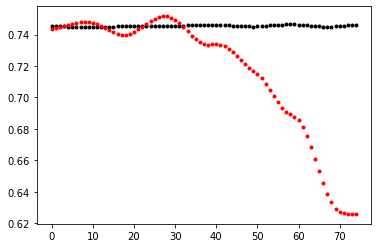

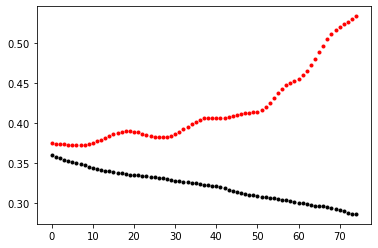

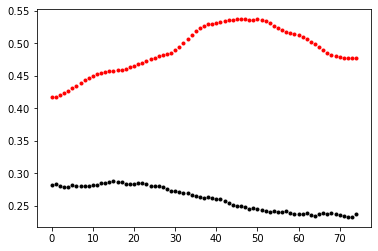

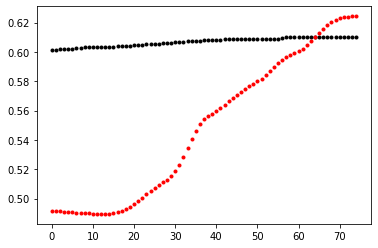

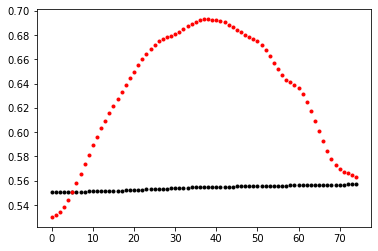

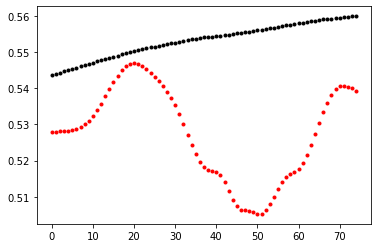

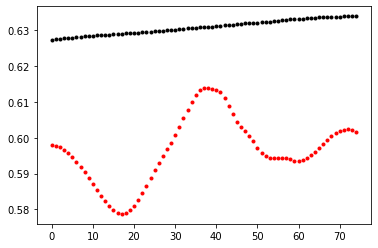

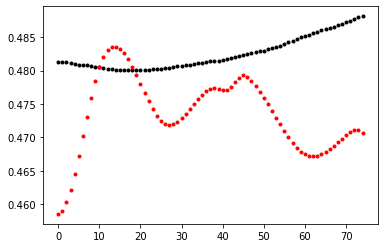

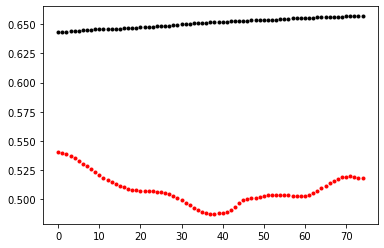

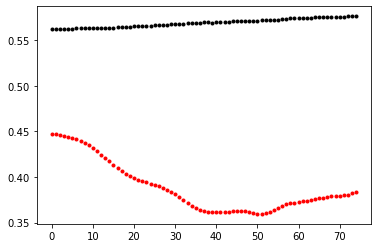

In [27]:
for i in range(len(Predictions)):
    plt.figure(i)
    plt.plot(Predictions[i,:],'k.')
    plt.plot(Values[i,:],'r.')